In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducible results
SEED = 90
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainset_transformed = torchvision.datasets.CIFAR10(root='./data', train=True,download=False, transform=transform)
trainloader_transformed = torch.utils.data.DataLoader(trainset_transformed, batch_size=batch_size,shuffle=True, num_workers=2)

testset_transformed = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader_transformed = torch.utils.data.DataLoader(testset_transformed, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


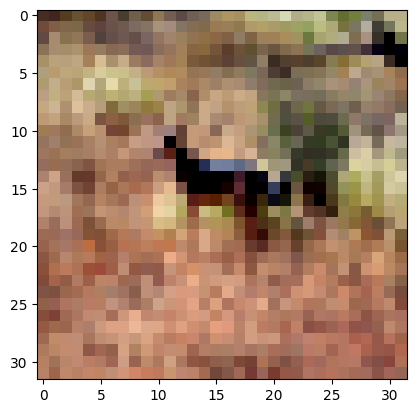

dog


In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_transformed)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0]))
# print labels
print(classes[labels[0]])

In [9]:
def train(num_epochs,trainset,device,optimizer,criterion,model):
  training_losses = []
  valid_losses = []
  training_accuracies = []
  total_size = len(trainset.dataset)
  train_size = int(total_size * (1 - 0.1))
  valid_size = total_size - train_size    
  # Splitting the dataset into training and validation sets
  train_dataset, valid_dataset = torch.utils.data.random_split(trainset.dataset, [train_size, valid_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=trainset.batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=trainset.batch_size, shuffle=False)
  
  model.to(device)
  
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    
    training_losses.append(running_loss / (i + 1))
    training_accuracy = 100 * correct / total
    training_accuracies.append(training_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}]: Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracy:.2f}%')
  return model, training_losses, training_accuracies, valid_losses

def test(class_names,testset,model,device,criterion):
    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    testing_losses = []
    testing_accuracies = []
    model.eval()
    with torch.no_grad():
        for data in testset:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            testing_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)
            testing_accuracies.append(batch_accuracy)

            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[class_names[label]] += 1
                total_pred[class_names[label]] += 1
    
    testing_accuracy = 100 * correct / total
    testing_loss = sum(testing_losses) / len(testing_losses)
    print(f'Accuracy of the network on the test images: {100 * correct // total} %\nTesting Accuracy: {testing_accuracy:.2f}%, Testing Loss: {testing_loss:.4f}')

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    return testing_loss, testing_accuracy, testing_losses, testing_accuracies


In [44]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28 , 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool1(self.relu2(self.conv2(x)))
        x = self.pool2(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Baseline CNN

### Baseline CNN Model1

In [ ]:
myCNN = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=0.0001)
num_epochs = 10
myCNN, training_losses, training_accuracies = train(num_epochs=num_epochs,
      trainset=trainloader_transformed,
        device=device,
      optimizer=optimizer,
      criterion=criterion,
      model=myCNN)
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=myCNN,
     device=device,
     criterion = criterion)


Epoch [1/10]: Training Loss: 2.2791, Training Accuracy: 21.90%\
Epoch [2/10]: Training Loss: 2.1539, Training Accuracy: 27.41%\
Epoch [3/10]: Training Loss: 1.9735, Training Accuracy: 31.74%\
Epoch [4/10]: Training Loss: 1.8424, Training Accuracy: 35.95%\
Epoch [5/10]: Training Loss: 1.7518, Training Accuracy: 38.63%\
Epoch [6/10]: Training Loss: 1.6914, Training Accuracy: 40.86%\
Epoch [7/10]: Training Loss: 1.6414, Training Accuracy: 42.59%\
Epoch [8/10]: Training Loss: 1.5956, Training Accuracy: 44.19%\
Epoch [9/10]: Training Loss: 1.5534, Training Accuracy: 45.71%\
Epoch [10/10]: Training Loss: 1.5173, Training Accuracy: 46.88%\
\
Accuracy of the network on the test images: 46 %\
\
Testing Accuracy: 46.87%, Testing Loss: 1.5144\
\
Accuracy for class: plane is 53.4 %\
Accuracy for class: car   is 66.0 %\
Accuracy for class: bird  is 42.7 %\
Accuracy for class: cat   is 28.1 %\
Accuracy for class: deer  is 39.8 %\
Accuracy for class: dog   is 31.0 %\
Accuracy for class: frog  is 61.3 %\
Accuracy for class: horse is 44.6 %\
Accuracy for class: ship  is 64.3 %\
Accuracy for class: truck is 37.5 %

### Baseline CNN Model2

In [ ]:
myCNN2 = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(myCNN2.parameters(), lr=0.0001)
num_epochs = 10
myCNN2, training_losses_2, training_accuracies_2 = train(num_epochs=num_epochs,
      trainset=trainloader_transformed,
        device=device,
      optimizer=optimizer_2,
      criterion=criterion,
      model=myCNN2)
testing_loss_2, testing_accuracy_2, testing_losses_2, testing_accuracies_2 = test(class_names=classes,
     testset=testloader_transformed,
     model=myCNN2,
     device=device,
     criterion = criterion)


Epoch [1/10]: Training Loss: 1.3391, Training Accuracy: 51.84%\
Epoch [2/10]: Training Loss: 0.9674, Training Accuracy: 65.75%\
Epoch [3/10]: Training Loss: 0.7154, Training Accuracy: 74.87%\
Epoch [4/10]: Training Loss: 0.4577, Training Accuracy: 84.14%\
Epoch [5/10]: Training Loss: 0.2357, Training Accuracy: 92.22%\
Epoch [6/10]: Training Loss: 0.1150, Training Accuracy: 96.26%\
Epoch [7/10]: Training Loss: 0.0760, Training Accuracy: 97.39%\
Epoch [8/10]: Training Loss: 0.0585, Training Accuracy: 98.11%\
Epoch [9/10]: Training Loss: 0.0455, Training Accuracy: 98.43%\
Epoch [10/10]: Training Loss: 0.0425, Training Accuracy: 98.64%\
\
Accuracy of the network on the test images: 65 %\
\
Testing Accuracy: 65.80%, Testing Loss: 2.1967\
\
Accuracy for class: plane is 69.5 %\
Accuracy for class: car   is 78.8 %\
Accuracy for class: bird  is 49.4 %\
Accuracy for class: cat   is 49.3 %\
Accuracy for class: deer  is 60.4 %\
Accuracy for class: dog   is 57.1 %\
Accuracy for class: frog  is 71.5 %\
Accuracy for class: horse is 68.8 %\
Accuracy for class: ship  is 81.9 %\
Accuracy for class: truck is 71.3 %

### Baseline CNN Model3

In [ ]:
myCNN3 = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer_2 = optim.RAdam(myCNN3.parameters(), lr=0.0001)
num_epochs = 10
myCNN3, training_losses_3, training_accuracies_3 = train(num_epochs=num_epochs,
      trainset=trainloader_transformed,
        device=device,
      optimizer=optimizer_2,
      criterion=criterion,
      model=myCNN3)
testing_loss_3, testing_accuracy_3, testing_losses_3, testing_accuracies_3 = test(class_names=classes,
     testset=testloader_transformed,
     model=myCNN3,
     device=device,
     criterion = criterion)

Epoch [1/10]: Training Loss: 1.4144, Training Accuracy: 49.51%\
Epoch [2/10]: Training Loss: 0.9884, Training Accuracy: 65.08%\
Epoch [3/10]: Training Loss: 0.7015, Training Accuracy: 75.51%\
Epoch [4/10]: Training Loss: 0.4003, Training Accuracy: 86.27%\
Epoch [5/10]: Training Loss: 0.1763, Training Accuracy: 94.11%\
Epoch [6/10]: Training Loss: 0.0900, Training Accuracy: 97.11%\
Epoch [7/10]: Training Loss: 0.0632, Training Accuracy: 97.95%\
Epoch [8/10]: Training Loss: 0.0512, Training Accuracy: 98.32%\
Epoch [9/10]: Training Loss: 0.0430, Training Accuracy: 98.58%\
Epoch [10/10]: Training Loss: 0.0368, Training Accuracy: 98.84%\
\
Accuracy of the network on the test images: 64 %\
\
Testing Accuracy: 64.81%, Testing Loss: 2.2765\
\
Accuracy for class: plane is 72.1 %\
Accuracy for class: car   is 73.9 %\
Accuracy for class: bird  is 52.6 %\
Accuracy for class: cat   is 45.7 %\
Accuracy for class: deer  is 62.9 %\
Accuracy for class: dog   is 54.5 %\
Accuracy for class: frog  is 70.5 %\
Accuracy for class: horse is 68.4 %\
Accuracy for class: ship  is 73.9 %\
Accuracy for class: truck is 73.6 %

# AlexNet

### AlexNet Model1

In [ ]:
alexnet_model = torchvision.models.alexnet(progress=True)
alexnet_model.classifier[6] = nn.Linear(4096, len(classes))
alexnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs

alexnet_model, training_losses, training_accuracies  = train(num_epochs=num_epochs,
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer,
      criterion=criterion,
      model=alexnet_model)
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=alexnet_model,
     device=device,
     criterion = criterion)

Epoch [1/10]: Training Loss: 2.3026, Training Accuracy: 10.13%\
Epoch [2/10]: Training Loss: 2.3026, Training Accuracy: 10.12%\
Epoch [3/10]: Training Loss: 2.3025, Training Accuracy: 10.19%\
Epoch [4/10]: Training Loss: 2.3025, Training Accuracy: 10.36%\
Epoch [5/10]: Training Loss: 2.3024, Training Accuracy: 10.65%\
Epoch [6/10]: Training Loss: 2.3024, Training Accuracy: 10.85%\
Epoch [7/10]: Training Loss: 2.3023, Training Accuracy: 11.24%\
Epoch [8/10]: Training Loss: 2.3023, Training Accuracy: 11.59%\
Epoch [9/10]: Training Loss: 2.3022, Training Accuracy: 11.85%\
Epoch [10/10]: Training Loss: 2.3021, Training Accuracy: 12.09%\
\
Accuracy of the network on the test images: 13 %\
\
Testing Accuracy: 13.75%, Testing Loss: 2.3020\
\
Accuracy for class: plane is 6.8 %\
Accuracy for class: car   is 7.9 %\
Accuracy for class: bird  is 0.0 %\
Accuracy for class: cat   is 0.0 %\
Accuracy for class: deer  is 0.0 %\
Accuracy for class: dog   is 97.2 %\
Accuracy for class: frog  is 0.0 %\
Accuracy for class: horse is 0.0 %\
Accuracy for class: ship  is 0.0 %\
Accuracy for class: truck is 25.6 % 

### AlexNet Model2

In [ ]:
alexnet_model2 = torchvision.models.alexnet(progress=True)
alexnet_model2.classifier[6] = nn.Linear(4096, len(classes))
alexnet_model2.to(device)
criterion_alx2 = nn.CrossEntropyLoss()
optimizer_alx2 = optim.Adam(alexnet_model2.parameters(), lr=0.0001)
num_epochs_alx2 = 10  
alexnet_model3, training_losses, training_accuracies  = train(num_epochs=num_epochs_alx2,
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_alx2,
      criterion=criterion_alx2,
      model=alexnet_model2)
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=alexnet_model2,
     device=device,
     criterion = criterion_alx2)


Epoch [1/10]: Training Loss: 1.4007, Training Accuracy: 48.90%\
Epoch [2/10]: Training Loss: 0.9209, Training Accuracy: 67.69%\
Epoch [3/10]: Training Loss: 0.7275, Training Accuracy: 74.61%\
Epoch [4/10]: Training Loss: 0.5995, Training Accuracy: 79.29%\
Epoch [5/10]: Training Loss: 0.5015, Training Accuracy: 82.68%\
Epoch [6/10]: Training Loss: 0.4233, Training Accuracy: 85.38%\
Epoch [7/10]: Training Loss: 0.3628, Training Accuracy: 87.39%\
Epoch [8/10]: Training Loss: 0.3097, Training Accuracy: 89.23%\
Epoch [9/10]: Training Loss: 0.2694, Training Accuracy: 90.79%\
Epoch [10/10]: Training Loss: 0.2414, Training Accuracy: 91.52%\
\
Accuracy of the network on the test images: 80 %\
\
Testing Accuracy: 80.94%, Testing Loss: 0.6654\
\
Accuracy for class: plane is 88.8 %\
Accuracy for class: car   is 91.5 %\
Accuracy for class: bird  is 72.6 %\
Accuracy for class: cat   is 56.3 %\
Accuracy for class: deer  is 83.8 %\
Accuracy for class: dog   is 68.0 %\
Accuracy for class: frog  is 91.7 %\
Accuracy for class: horse is 82.6 %\
Accuracy for class: ship  is 88.6 %\
Accuracy for class: truck is 85.5 %

### AlexNet Model3

In [ ]:
alexnet_model3 = torchvision.models.alexnet(weights= torchvision.models.AlexNet_Weights.IMAGENET1K_V1)
alexnet_model3.classifier[6] = nn.Linear(4096, len(classes))
alexnet_model3.to(device)
criterion_alx3 = nn.CrossEntropyLoss()
optimizer_alx3 = optim.RAdam(alexnet_model3.parameters(), lr=0.0001)
num_epochs_alx3 = 10  # Adjust the number of training epochs
alexnet_model3, training_losses, training_accuracies  = train(num_epochs=num_epochs_alx3,
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_alx3,
      criterion=criterion_alx3,
      model=alexnet_model3)
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=alexnet_model3,
     device=device,
     criterion = criterion_alx3)


Epoch [1/10]: Training Loss: 0.6436, Training Accuracy: 77.72%\
Epoch [2/10]: Training Loss: 0.3954, Training Accuracy: 86.63%\
Epoch [3/10]: Training Loss: 0.2993, Training Accuracy: 89.81%\
Epoch [4/10]: Training Loss: 0.2357, Training Accuracy: 92.07%\
Epoch [5/10]: Training Loss: 0.1970, Training Accuracy: 93.37%\
Epoch [6/10]: Training Loss: 0.1718, Training Accuracy: 94.28%\
Epoch [7/10]: Training Loss: 0.1538, Training Accuracy: 95.08%\
Epoch [8/10]: Training Loss: 0.1436, Training Accuracy: 95.37%\
Epoch [9/10]: Training Loss: 0.1329, Training Accuracy: 95.71%\
Epoch [10/10]: Training Loss: 0.1257, Training Accuracy: 95.99%\
\
Accuracy of the network on the test images: 86 %\
\
Testing Accuracy: 86.02%, Testing Loss: 0.5766\
\
Accuracy for class: plane is 85.2 %\
Accuracy for class: car   is 83.0 %\
Accuracy for class: bird  is 81.9 %\
Accuracy for class: cat   is 71.1 %\
Accuracy for class: deer  is 93.1 %\
Accuracy for class: dog   is 80.8 %\
Accuracy for class: frog  is 94.2 %\
Accuracy for class: horse is 87.0 %\
Accuracy for class: ship  is 86.8 %\
Accuracy for class: truck is 97.1 %

# VGGNet

### Vgg11 Model1

In [ ]:
vgg11_model1 = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.IMAGENET1K_V1,progress=False)
vgg11_model1.classifier[6] = nn.Linear(4096, len(classes))
vgg11_model1.to(device)
criterion_vgg11 = nn.CrossEntropyLoss()
optimizer_vgg11_1 = optim.SGD(vgg11_model1.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
vgg11_model1, training_losses_vgg11_1 , training_accuracies_vgg11_1   = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_vgg11_1,
      criterion=criterion_vgg11,
      model=vgg11_model1)

Epoch [1/10]: Training Loss: 1.0896, Training Accuracy: 61.45%\
Epoch [2/10]: Training Loss: 0.5696, Training Accuracy: 80.17%\
Epoch [3/10]: Training Loss: 0.4723, Training Accuracy: 83.50%\
Epoch [4/10]: Training Loss: 0.4126, Training Accuracy: 85.48%\
Epoch [5/10]: Training Loss: 0.3750, Training Accuracy: 86.75%\
Epoch [6/10]: Training Loss: 0.3487, Training Accuracy: 87.85%\
Epoch [7/10]: Training Loss: 0.3206, Training Accuracy: 88.71%\
Epoch [8/10]: Training Loss: 0.3023, Training Accuracy: 89.56%\
Epoch [9/10]: Training Loss: 0.2840, Training Accuracy: 90.05%\
Epoch [10/10]: Training Loss: 0.2691, Training Accuracy: 90.62%

In [10]:
testing_loss_vgg11_1 , testing_accuracy_vgg11_1 , testing_losses_vgg11_1 , testing_accuracies_vgg11_1  = test(class_names=classes,
     testset=testloader_transformed,
     model=vgg11_model1,
     device=device,
     criterion = criterion_vgg11)

Accuracy of the network on the test images: 90 %
Testing Accuracy: 90.12%, Testing Loss: 0.2847
Accuracy for class: plane is 92.5 %
Accuracy for class: car   is 95.5 %
Accuracy for class: bird  is 88.4 %
Accuracy for class: cat   is 80.8 %
Accuracy for class: deer  is 89.6 %
Accuracy for class: dog   is 83.3 %
Accuracy for class: frog  is 93.9 %
Accuracy for class: horse is 91.3 %
Accuracy for class: ship  is 93.9 %
Accuracy for class: truck is 92.0 %


### Vgg11 Model2

In [ ]:
vgg11_model2 = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.IMAGENET1K_V1,progress=False)
vgg11_model2.classifier[6] = nn.Linear(4096, len(classes))
vgg11_model2.to(device)
criterion_vgg11 = nn.CrossEntropyLoss()
optimizer_vgg11_2 = optim.Adam(vgg11_model2.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
vgg11_model2, training_losses_vgg11_2 , training_accuracies_vgg11_2   = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_vgg11_2,
      criterion=criterion_vgg11,
      model=vgg11_model2)
testing_loss_vgg11_2 , testing_accuracy_vgg11_2 , testing_losses_vgg11_2 , testing_accuracies_vgg11_2  = test(class_names=classes,
     testset=testloader_transformed,
     model=vgg11_model2,
     device=device,
     criterion = criterion_vgg11)

Epoch [1/10]: Training Loss: 0.5827, Training Accuracy: 80.13%\
Epoch [2/10]: Training Loss: 0.2969, Training Accuracy: 90.14%\
Epoch [3/10]: Training Loss: 0.1952, Training Accuracy: 93.53%\
Epoch [4/10]: Training Loss: 0.1445, Training Accuracy: 95.25%\
Epoch [5/10]: Training Loss: 0.1150, Training Accuracy: 96.29%\
Epoch [6/10]: Training Loss: 0.0969, Training Accuracy: 96.97%\
Epoch [7/10]: Training Loss: 0.0957, Training Accuracy: 97.12%\
Epoch [8/10]: Training Loss: 0.0893, Training Accuracy: 97.39%\
Epoch [9/10]: Training Loss: 0.0890, Training Accuracy: 97.45%\
Epoch [10/10]: Training Loss: 0.0806, Training Accuracy: 97.68%\
\
Accuracy of the network on the test images: 88 %\
\
Testing Accuracy: 88.58%, Testing Loss: 0.4920\
\
Accuracy for class: plane is 87.2 %\
Accuracy for class: car   is 94.4 %\
Accuracy for class: bird  is 80.3 %\
Accuracy for class: cat   is 81.3 %\
Accuracy for class: deer  is 85.7 %\
Accuracy for class: dog   is 88.1 %\
Accuracy for class: frog  is 91.2 %\
Accuracy for class: horse is 91.5 %\
Accuracy for class: ship  is 93.2 %\
Accuracy for class: truck is 92.9 %

### Vgg11 Model3

In [ ]:
vgg11_model3 = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.IMAGENET1K_V1,progress=True)
vgg11_model3.classifier[6] = nn.Linear(4096, len(classes))
vgg11_model3.to(device)
criterion_vgg11 = nn.CrossEntropyLoss()
optimizer_vgg11_3 = optim.RAdam(vgg11_model3.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
vgg11_model3, training_losses_vgg11_3 , training_accuracies_vgg11_3   = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_vgg11_3,
      criterion=criterion_vgg11,
      model=vgg11_model3)
testing_loss_vgg11_3 , testing_accuracy_vgg11_3 , testing_losses_vgg11_3 , testing_accuracies_vgg11_3  = test(class_names=classes,
     testset=testloader_transformed,
     model=vgg11_model3,
     device=device,
     criterion = criterion_vgg11)

Epoch [1/10]: Training Loss: 0.5724, Training Accuracy: 80.55%\
Epoch [2/10]: Training Loss: 0.3129, Training Accuracy: 89.52%\
Epoch [3/10]: Training Loss: 0.2053, Training Accuracy: 93.31%\
Epoch [4/10]: Training Loss: 0.1500, Training Accuracy: 95.10%\
Epoch [5/10]: Training Loss: 0.1185, Training Accuracy: 96.27%\
Epoch [6/10]: Training Loss: 0.1023, Training Accuracy: 96.75%\
Epoch [7/10]: Training Loss: 0.0891, Training Accuracy: 97.21%\
Epoch [8/10]: Training Loss: 0.0881, Training Accuracy: 97.33%\
Epoch [9/10]: Training Loss: 0.0811, Training Accuracy: 97.56%\
Epoch [10/10]: Training Loss: 0.0813, Training Accuracy: 97.70%\
\
Accuracy of the network on the test images: 89 %\
\
Testing Accuracy: 89.30%, Testing Loss: 0.4568\
\
Accuracy for class: plane is 89.5 %\
Accuracy for class: car   is 97.4 %\
Accuracy for class: bird  is 89.4 %\
Accuracy for class: cat   is 82.6 %\
Accuracy for class: deer  is 86.4 %\
Accuracy for class: dog   is 85.9 %\
Accuracy for class: frog  is 90.4 %\
Accuracy for class: horse is 93.7 %\
Accuracy for class: ship  is 85.2 %\
Accuracy for class: truck is 92.5 %

## ResNet 

### ResNet101 Model1

In [ ]:
resnet_model101 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101.fc.in_features
resnet_model101.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101 = optim.SGD(resnet_model101.parameters(), lr=0.01)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101, training_losses, training_accuracies = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101,
      criterion=criterion_res101,
      model=resnet_model101)


Epoch [1/10]: Training Loss: 0.8257, Training Accuracy: 71.77%\
Epoch [2/10]: Training Loss: 0.7134, Training Accuracy: 75.86%\
Epoch [3/10]: Training Loss: 0.6907, Training Accuracy: 76.56%\
Epoch [4/10]: Training Loss: 0.6845, Training Accuracy: 77.00%\
Epoch [5/10]: Training Loss: 0.6663, Training Accuracy: 77.32%\
Epoch [6/10]: Training Loss: 0.6543, Training Accuracy: 77.76%\
Epoch [7/10]: Training Loss: 0.6504, Training Accuracy: 78.03%\
Epoch [8/10]: Training Loss: 0.6508, Training Accuracy: 78.04%\
Epoch [9/10]: Training Loss: 0.6358, Training Accuracy: 78.39%\
Epoch [10/10]: Training Loss: 0.6286, Training Accuracy: 78.64%

In [67]:
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101,
     device=device,
    criterion = criterion_res101)

Accuracy of the network on the test images: 82 %
Testing Accuracy: 82.03%, Testing Loss: 0.7657
Accuracy for class: plane is 66.5 %
Accuracy for class: car   is 83.3 %
Accuracy for class: bird  is 84.4 %
Accuracy for class: cat   is 67.8 %
Accuracy for class: deer  is 77.4 %
Accuracy for class: dog   is 80.3 %
Accuracy for class: frog  is 92.0 %
Accuracy for class: horse is 87.5 %
Accuracy for class: ship  is 88.7 %
Accuracy for class: truck is 92.4 %


In [ ]:
resnet_model101 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101.fc.in_features
resnet_model101.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101 = optim.SGD(resnet_model101.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101, training_losses, training_accuracies = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101,
      criterion=criterion_res101,
      model=resnet_model101)
testing_loss, testing_accuracy, testing_losses, testing_accuracies = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101,
     device=device,
    criterion = criterion_res101)

Epoch [1/10]: Training Loss: 1.9005, Training Accuracy: 50.24%\
Epoch [2/10]: Training Loss: 1.4369, Training Accuracy: 67.16%\
Epoch [3/10]: Training Loss: 1.2229, Training Accuracy: 69.78%\
Epoch [4/10]: Training Loss: 1.1044, Training Accuracy: 70.85%\
Epoch [5/10]: Training Loss: 1.0262, Training Accuracy: 71.65%\
Epoch [6/10]: Training Loss: 0.9748, Training Accuracy: 72.07%\
Epoch [7/10]: Training Loss: 0.9295, Training Accuracy: 73.14%\
Epoch [8/10]: Training Loss: 0.9056, Training Accuracy: 73.02%\
Epoch [9/10]: Training Loss: 0.8805, Training Accuracy: 73.49%\
Epoch [10/10]: Training Loss: 0.8541, Training Accuracy: 74.14%\
\
Accuracy of the network on the test images: 78 %\
\
Testing Accuracy: 78.20%, Testing Loss: 0.7048\
\
Accuracy for class: plane is 67.6 %\
Accuracy for class: car   is 84.5 %\
Accuracy for class: bird  is 69.6 %\
Accuracy for class: cat   is 62.8 %\
Accuracy for class: deer  is 73.1 %\
Accuracy for class: dog   is 80.4 %\
Accuracy for class: frog  is 85.2 %\
Accuracy for class: horse is 79.5 %\
Accuracy for class: ship  is 90.4 %\
Accuracy for class: truck is 88.9 %

### ResNet101 Model2

In [ ]:
resnet_model101_2 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101_2.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101_2.fc.in_features
resnet_model101_2.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101_2 = optim.Adam(resnet_model101_2.parameters(), lr=0.01)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101_2, training_losses, training_accuracies = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101_2,
      criterion=criterion_res101,
      model=resnet_model101_2)
testing_loss , testing_accuracy, testing_losses , testing_accuracies  = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101_2,
     device=device,
    criterion = criterion_res101)


Epoch [1/10]: Training Loss: 3.5715, Training Accuracy: 65.47%\
Epoch [2/10]: Training Loss: 3.9997, Training Accuracy: 69.51%\
Epoch [3/10]: Training Loss: 3.9039, Training Accuracy: 70.50%\
Epoch [4/10]: Training Loss: 3.8958, Training Accuracy: 71.45%\
Epoch [5/10]: Training Loss: 3.8091, Training Accuracy: 71.75%\
Epoch [6/10]: Training Loss: 3.8056, Training Accuracy: 72.36%\
Epoch [7/10]: Training Loss: 3.8267, Training Accuracy: 72.41%\
Epoch [8/10]: Training Loss: 3.8671, Training Accuracy: 72.69%\
Epoch [9/10]: Training Loss: 3.8078, Training Accuracy: 72.93%\
Epoch [10/10]: Training Loss: 3.8146, Training Accuracy: 73.06%\
\
Accuracy of the network on the test images: 79 %\
\
Testing Accuracy: 79.56%, Testing Loss: 3.1988\
\
Accuracy for class: plane is 77.0 %\
Accuracy for class: car   is 81.6 %\
Accuracy for class: bird  is 82.3 %\
Accuracy for class: cat   is 62.8 %\
Accuracy for class: deer  is 52.3 %\
Accuracy for class: dog   is 84.1 %\
Accuracy for class: frog  is 94.6 %\
Accuracy for class: horse is 77.8 %\
Accuracy for class: ship  is 91.5 %\
Accuracy for class: truck is 91.6 %

In [ ]:
resnet_model101_2 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101_2.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101_2.fc.in_features
resnet_model101_2.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101_2 = optim.Adam(resnet_model101_2.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101_2, training_losses, training_accuracies = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101_2,
      criterion=criterion_res101,
      model=resnet_model101_2)
testing_loss , testing_accuracy, testing_losses , testing_accuracies  = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101_2,
     device=device,
    criterion = criterion_res101)


Epoch [1/10]: Training Loss: 1.0185, Training Accuracy: 69.62%\
Epoch [2/10]: Training Loss: 0.7330, Training Accuracy: 75.71%\
Epoch [3/10]: Training Loss: 0.6932, Training Accuracy: 76.54%\
Epoch [4/10]: Training Loss: 0.6682, Training Accuracy: 77.26%\
Epoch [5/10]: Training Loss: 0.6576, Training Accuracy: 77.66%\
Epoch [6/10]: Training Loss: 0.6532, Training Accuracy: 77.69%\
Epoch [7/10]: Training Loss: 0.6438, Training Accuracy: 78.08%\
Epoch [8/10]: Training Loss: 0.6374, Training Accuracy: 78.48%\
Epoch [9/10]: Training Loss: 0.6332, Training Accuracy: 78.47%\
Epoch [10/10]: Training Loss: 0.6249, Training Accuracy: 78.87%\
\
Accuracy of the network on the test images: 82 %\
\
Testing Accuracy: 82.16%, Testing Loss: 0.6477\
\
Accuracy for class: plane is 70.5 %\
Accuracy for class: car   is 85.5 %\
Accuracy for class: bird  is 81.2 %\
Accuracy for class: cat   is 74.6 %\
Accuracy for class: deer  is 80.2 %\
Accuracy for class: dog   is 79.1 %\
Accuracy for class: frog  is 91.7 %\
Accuracy for class: horse is 81.4 %\
Accuracy for class: ship  is 86.0 %\
Accuracy for class: truck is 91.4 %

### ResNet101 Model3

In [ ]:
resnet_model101_3 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101_3.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101_3.fc.in_features
resnet_model101_3.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101_3 = optim.RAdam(resnet_model101_3.parameters(), lr=0.01)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101_3, training_losses_3, training_accuracies_3 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101_3,
      criterion=criterion_res101,
      model=resnet_model101_3)
testing_loss_3 , testing_accuracy_3, testing_losses_3 , testing_accuracies_3  = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101_3,
     device=device,
     criterion = criterion_res101)


Epoch [1/10]: Training Loss: 3.0966, Training Accuracy: 64.20%\
Epoch [2/10]: Training Loss: 3.9928, Training Accuracy: 69.23%\
Epoch [3/10]: Training Loss: 3.8974, Training Accuracy: 70.57%\
Epoch [4/10]: Training Loss: 3.9832, Training Accuracy: 70.85%\
Epoch [5/10]: Training Loss: 3.8258, Training Accuracy: 71.83%\
Epoch [6/10]: Training Loss: 3.7904, Training Accuracy: 72.08%\
Epoch [7/10]: Training Loss: 3.9163, Training Accuracy: 72.32%\
Epoch [8/10]: Training Loss: 3.7348, Training Accuracy: 72.98%\
Epoch [9/10]: Training Loss: 3.6997, Training Accuracy: 73.31%\
Epoch [10/10]: Training Loss: 3.8766, Training Accuracy: 73.03%\
\
Accuracy of the network on the test images: 77 %\
\
Testing Accuracy: 77.41%, Testing Loss: 4.3976\
\
Accuracy for class: plane is 60.8 %\
Accuracy for class: car   is 87.9 %\
Accuracy for class: bird  is 77.2 %\
Accuracy for class: cat   is 87.8 %\
Accuracy for class: deer  is 81.5 %\
Accuracy for class: dog   is 46.6 %\
Accuracy for class: frog  is 72.7 %\
Accuracy for class: horse is 88.0 %\
Accuracy for class: ship  is 93.5 %\
Accuracy for class: truck is 78.1 %

In [ ]:
resnet_model101_3 = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)
for param in resnet_model101_3.parameters():
    param.requires_grad = False
num_ftrs = resnet_model101_3.fc.in_features
resnet_model101_3.fc = nn.Linear(num_ftrs, len(classes))
criterion_res101 = nn.CrossEntropyLoss()
optimizer_res101_3 = optim.RAdam(resnet_model101_3.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet_model101_3, training_losses_3, training_accuracies_3 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res101_3,
      criterion=criterion_res101,
      model=resnet_model101_3)
testing_loss_3 , testing_accuracy_3, testing_losses_3 , testing_accuracies_3  = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet_model101_3,
     device=device,
     criterion = criterion_res101)

Epoch [1/10]: Training Loss: 1.1608, Training Accuracy: 65.88%\
Epoch [2/10]: Training Loss: 0.7452, Training Accuracy: 75.44%\
Epoch [3/10]: Training Loss: 0.6977, Training Accuracy: 76.43%\
Epoch [4/10]: Training Loss: 0.6708, Training Accuracy: 77.21%\
Epoch [5/10]: Training Loss: 0.6594, Training Accuracy: 77.60%\
Epoch [6/10]: Training Loss: 0.6546, Training Accuracy: 77.66%\
Epoch [7/10]: Training Loss: 0.6448, Training Accuracy: 78.04%\
Epoch [8/10]: Training Loss: 0.6383, Training Accuracy: 78.44%\
Epoch [9/10]: Training Loss: 0.6341, Training Accuracy: 78.44%\
Epoch [10/10]: Training Loss: 0.6257, Training Accuracy: 78.83%\
\
Accuracy of the network on the test images: 82 %\
\
Testing Accuracy: 82.15%, Testing Loss: 0.6478\
\
Accuracy for class: plane is 70.6 %\
Accuracy for class: car   is 85.5 %\
Accuracy for class: bird  is 81.2 %\
Accuracy for class: cat   is 74.7 %\
Accuracy for class: deer  is 80.1 %\
Accuracy for class: dog   is 79.1 %\
Accuracy for class: frog  is 91.6 %\
Accuracy for class: horse is 81.4 %\
Accuracy for class: ship  is 86.0 %\
Accuracy for class: truck is 91.3 %

## ResNet 18

### ResNet18 Model1

In [74]:
resnet18_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18 = nn.CrossEntropyLoss()
optimizer_res18 = optim.SGD(resnet18_model.parameters(), lr=0.01)
num_epochs = 10  
resnet18_model, training_losses_res18, training_accuracies_res18 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18,
      criterion=criterion_res18,
      model=resnet18_model)


Epoch [1/10]: Training Loss: 0.9246, Training Accuracy: 68.75%
Epoch [2/10]: Training Loss: 0.8242, Training Accuracy: 72.26%
Epoch [3/10]: Training Loss: 0.8164, Training Accuracy: 72.56%
Epoch [4/10]: Training Loss: 0.8019, Training Accuracy: 72.92%
Epoch [5/10]: Training Loss: 0.7969, Training Accuracy: 73.23%
Epoch [6/10]: Training Loss: 0.7975, Training Accuracy: 73.27%
Epoch [7/10]: Training Loss: 0.7937, Training Accuracy: 73.35%
Epoch [8/10]: Training Loss: 0.7939, Training Accuracy: 73.40%
Epoch [9/10]: Training Loss: 0.7904, Training Accuracy: 73.46%
Epoch [10/10]: Training Loss: 0.7904, Training Accuracy: 73.34%


In [75]:
testing_loss_res18, testing_accuracy_res18, testing_losses_res18, testing_accuracies_res18 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model
     device=device,
     criterion = criterion_res18)

Accuracy of the network on the test images: 79 %
Testing Accuracy: 79.31%, Testing Loss: 0.6171
Accuracy for class: plane is 73.3 %
Accuracy for class: car   is 89.0 %
Accuracy for class: bird  is 81.6 %
Accuracy for class: cat   is 56.0 %
Accuracy for class: deer  is 70.5 %
Accuracy for class: dog   is 70.9 %
Accuracy for class: frog  is 89.8 %
Accuracy for class: horse is 86.3 %
Accuracy for class: ship  is 88.1 %
Accuracy for class: truck is 87.6 %


In [ ]:
resnet18_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18 = nn.CrossEntropyLoss()
optimizer_res18 = optim.SGD(resnet18_model.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet18_model, training_losses_res18, training_accuracies_res18 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18,
      criterion=criterion_res18,
      model=resnet18_model)
testing_loss_res18, testing_accuracy_res18, testing_losses_res18, testing_accuracies_res18 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model,
     device=device,
     criterion = criterion_res18)

Epoch [1/10]: Training Loss: 1.9078, Training Accuracy: 38.91%\
Epoch [2/10]: Training Loss: 1.4792, Training Accuracy: 58.74%\
Epoch [3/10]: Training Loss: 1.2819, Training Accuracy: 63.89%\
Epoch [4/10]: Training Loss: 1.1670, Training Accuracy: 66.07%\
Epoch [5/10]: Training Loss: 1.0994, Training Accuracy: 67.25%\
Epoch [6/10]: Training Loss: 1.0449, Training Accuracy: 68.29%\
Epoch [7/10]: Training Loss: 1.0088, Training Accuracy: 68.92%\
Epoch [8/10]: Training Loss: 0.9796, Training Accuracy: 69.35%\
Epoch [9/10]: Training Loss: 0.9586, Training Accuracy: 69.77%\
Epoch [10/10]: Training Loss: 0.9367, Training Accuracy: 70.16%\
\
Accuracy of the network on the test images: 75 %\
\
Testing Accuracy: 75.78%, Testing Loss: 0.7566\
Accuracy for class: plane is 80.0 %\
Accuracy for class: car   is 89.3 %\
Accuracy for class: bird  is 61.5 %\
Accuracy for class: cat   is 63.7 %\
Accuracy for class: deer  is 65.2 %\
Accuracy for class: dog   is 71.2 %\
Accuracy for class: frog  is 83.2 %\
Accuracy for class: horse is 76.3 %\
Accuracy for class: ship  is 82.5 %\
Accuracy for class: truck is 84.9 %

### ResNet18 Model2

In [92]:
resnet18_model2 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model2.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model2.fc.in_features
resnet18_model2.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18_2 = nn.CrossEntropyLoss()
optimizer_res18_2 = optim.Adam(resnet18_model2.parameters(), lr=0.01)
num_epochs = 10  # Adjust the number of training epochs
resnet18_model2, training_losses_res18_2, training_accuracies_res18_2 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18_2,
      criterion=criterion_res18_2,
      model=resnet18_model2)


Epoch [1/10]: Training Loss: 2.1459, Training Accuracy: 62.53%
Epoch [2/10]: Training Loss: 2.3419, Training Accuracy: 65.25%
Epoch [3/10]: Training Loss: 2.3788, Training Accuracy: 65.63%
Epoch [4/10]: Training Loss: 2.3487, Training Accuracy: 66.08%
Epoch [5/10]: Training Loss: 2.3623, Training Accuracy: 66.27%
Epoch [6/10]: Training Loss: 2.3896, Training Accuracy: 66.36%
Epoch [7/10]: Training Loss: 2.3618, Training Accuracy: 66.29%
Epoch [8/10]: Training Loss: 2.3843, Training Accuracy: 66.59%
Epoch [9/10]: Training Loss: 2.4049, Training Accuracy: 66.33%
Epoch [10/10]: Training Loss: 2.3903, Training Accuracy: 66.63%


In [93]:
testing_loss_res18_2, testing_accuracy_res18_2, testing_losses_res18_2, testing_accuracies_res18_2 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model2,
     device=device,
     criterion = criterion_res18_2)

Accuracy of the network on the test images: 73 %
Testing Accuracy: 73.55%, Testing Loss: 1.8264
Accuracy for class: plane is 75.6 %
Accuracy for class: car   is 92.2 %
Accuracy for class: bird  is 72.0 %
Accuracy for class: cat   is 47.4 %
Accuracy for class: deer  is 52.4 %
Accuracy for class: dog   is 74.2 %
Accuracy for class: frog  is 94.5 %
Accuracy for class: horse is 76.6 %
Accuracy for class: ship  is 84.9 %
Accuracy for class: truck is 65.7 %


In [ ]:
resnet18_model2 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model2.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model2.fc.in_features
resnet18_model2.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18_2 = nn.CrossEntropyLoss()
optimizer_res18_2 = optim.Adam(resnet18_model2.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet18_model2, training_losses_res18_2, training_accuracies_res18_2 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18_2,
      criterion=criterion_res18_2,
      model=resnet18_model2)
testing_loss_res18_2, testing_accuracy_res18_2, testing_losses_res18_2, testing_accuracies_res18_2 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model2,
     device=device,
     criterion = criterion_res18_2)

Epoch [1/10]: Training Loss: 1.2490, Training Accuracy: 61.54%\
Epoch [2/10]: Training Loss: 0.8856, Training Accuracy: 70.90%\
Epoch [3/10]: Training Loss: 0.8233, Training Accuracy: 72.37%\
Epoch [4/10]: Training Loss: 0.7962, Training Accuracy: 73.11%\
Epoch [5/10]: Training Loss: 0.7753, Training Accuracy: 73.92%\
Epoch [6/10]: Training Loss: 0.7734, Training Accuracy: 73.85%\
Epoch [7/10]: Training Loss: 0.7586, Training Accuracy: 74.21%\
Epoch [8/10]: Training Loss: 0.7599, Training Accuracy: 74.07%\
Epoch [9/10]: Training Loss: 0.7566, Training Accuracy: 74.31%\
Epoch [10/10]: Training Loss: 0.7473, Training Accuracy: 74.74%\
\
Accuracy of the network on the test images: 80 %\
\
Testing Accuracy: 80.00%, Testing Loss: 0.5902\
\
Accuracy for class: plane is 86.7 %\
Accuracy for class: car   is 86.4 %\
Accuracy for class: bird  is 71.8 %\
Accuracy for class: cat   is 68.8 %\
Accuracy for class: deer  is 71.0 %\
Accuracy for class: dog   is 75.0 %\
Accuracy for class: frog  is 85.2 %\
Accuracy for class: horse is 86.8 %\
Accuracy for class: ship  is 83.4 %\
Accuracy for class: truck is 84.9 %

### ResNet18 Model3

In [96]:
resnet18_model3 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model3.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model3.fc.in_features
resnet18_model3.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18_3 = nn.CrossEntropyLoss()
optimizer_res18_3 = optim.RAdam(resnet18_model3.parameters(), lr=0.01)
num_epochs = 10  # Adjust the number of training epochs
resnet18_model3, training_losses_res18_3, training_accuracies_res18_3 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18_3,
      criterion=criterion_res18_3,
      model=resnet18_model3)


Epoch [1/10]: Training Loss: 1.8953, Training Accuracy: 62.09%
Epoch [2/10]: Training Loss: 2.3001, Training Accuracy: 64.96%
Epoch [3/10]: Training Loss: 2.3514, Training Accuracy: 65.77%
Epoch [4/10]: Training Loss: 2.4140, Training Accuracy: 65.92%
Epoch [5/10]: Training Loss: 2.3909, Training Accuracy: 66.53%
Epoch [6/10]: Training Loss: 2.3904, Training Accuracy: 66.02%
Epoch [7/10]: Training Loss: 2.4286, Training Accuracy: 66.37%
Epoch [8/10]: Training Loss: 2.4078, Training Accuracy: 66.36%
Epoch [9/10]: Training Loss: 2.4286, Training Accuracy: 66.41%
Epoch [10/10]: Training Loss: 2.3624, Training Accuracy: 66.61%


In [ ]:
testing_loss_res18_3, testing_accuracy_res18_3, testing_losses_res18_3, testing_accuracies_res18_3 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model3,
     device=device,
     criterion = criterion_res18_3)

Accuracy of the network on the test images: 75 %\
\
Testing Accuracy: 75.29%, Testing Loss: 1.6371\
\
Accuracy for class: plane is 70.6 %\
Accuracy for class: car   is 94.4 %\
Accuracy for class: bird  is 77.8 %\
Accuracy for class: cat   is 74.2 %\
Accuracy for class: deer  is 55.5 %\
Accuracy for class: dog   is 50.5 %\
Accuracy for class: frog  is 82.2 %\
Accuracy for class: horse is 85.6 %\
Accuracy for class: ship  is 88.2 %\
Accuracy for class: truck is 73.9 %

In [ ]:
resnet18_model3 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model3.parameters():
    param.requires_grad = False
num_ftrs = resnet18_model3.fc.in_features
resnet18_model3.fc = nn.Linear(num_ftrs, len(classes))
criterion_res18_3 = nn.CrossEntropyLoss()
optimizer_res18_3 = optim.RAdam(resnet18_model3.parameters(), lr=0.0001)
num_epochs = 10  # Adjust the number of training epochs
resnet18_model3, training_losses_res18_3, training_accuracies_res18_3 = train(num_epochs=num_epochs, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_res18_3,
      criterion=criterion_res18_3,
      model=resnet18_model3)
testing_loss_res18_3, testing_accuracy_res18_3, testing_losses_res18_3, testing_accuracies_res18_3 = test(class_names=classes,
     testset=testloader_transformed,
     model=resnet18_model3,
     device=device,
     criterion = criterion_res18_3)

Epoch [1/10]: Training Loss: 1.4142, Training Accuracy: 55.83%\
Epoch [2/10]: Training Loss: 0.9028, Training Accuracy: 70.55%\
Epoch [3/10]: Training Loss: 0.8296, Training Accuracy: 72.19%\
Epoch [4/10]: Training Loss: 0.7999, Training Accuracy: 73.12%\
Epoch [5/10]: Training Loss: 0.7790, Training Accuracy: 73.78%\
Epoch [6/10]: Training Loss: 0.7714, Training Accuracy: 73.87%\
Epoch [7/10]: Training Loss: 0.7625, Training Accuracy: 74.29%\
Epoch [8/10]: Training Loss: 0.7575, Training Accuracy: 74.32%\
Epoch [9/10]: Training Loss: 0.7568, Training Accuracy: 74.14%\
Epoch [10/10]: Training Loss: 0.7494, Training Accuracy: 74.63%\
\
Accuracy of the network on the test images: 79 %\
\
Testing Accuracy: 79.58%, Testing Loss: 0.5912\
\
Accuracy for class: plane is 82.9 %\
Accuracy for class: car   is 86.3 %\
Accuracy for class: bird  is 72.0 %\
Accuracy for class: cat   is 68.2 %\
Accuracy for class: deer  is 69.7 %\
Accuracy for class: dog   is 76.7 %\
Accuracy for class: frog  is 84.8 %\
Accuracy for class: horse is 82.7 %\
Accuracy for class: ship  is 87.1 %\
Accuracy for class: truck is 85.4 %

# GoogLeNet

### GoogLeNet Model1

In [77]:
googlenet_model = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Linear(num_ftrs, len(classes))

criterion_ggl = nn.CrossEntropyLoss()
optimizer_ggl = optim.SGD(googlenet_model.parameters(), lr=0.01)
num_epochs_ggl = 10  
googlenet_model, training_losses_ggl, training_accuracies_ggl  = train(num_epochs=num_epochs_ggl, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl,
      criterion=criterion_ggl,
      model=googlenet_model)


Epoch [1/10]: Training Loss: 0.5075, Training Accuracy: 83.41%
Epoch [2/10]: Training Loss: 0.2556, Training Accuracy: 91.58%
Epoch [3/10]: Training Loss: 0.1773, Training Accuracy: 94.00%
Epoch [4/10]: Training Loss: 0.1278, Training Accuracy: 95.77%
Epoch [5/10]: Training Loss: 0.1006, Training Accuracy: 96.67%
Epoch [6/10]: Training Loss: 0.0749, Training Accuracy: 97.50%
Epoch [7/10]: Training Loss: 0.0639, Training Accuracy: 97.91%
Epoch [8/10]: Training Loss: 0.0502, Training Accuracy: 98.35%
Epoch [9/10]: Training Loss: 0.0487, Training Accuracy: 98.39%
Epoch [10/10]: Training Loss: 0.0397, Training Accuracy: 98.71%


In [79]:
testing_loss_ggl, testing_accuracy_ggl, testing_losses_ggl, testing_accuracies_ggl = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model,
     device=device,
     criterion = criterion_ggl)

Accuracy of the network on the test images: 94 %
Testing Accuracy: 94.80%, Testing Loss: 0.1806
Accuracy for class: plane is 95.2 %
Accuracy for class: car   is 96.2 %
Accuracy for class: bird  is 93.2 %
Accuracy for class: cat   is 88.4 %
Accuracy for class: deer  is 96.2 %
Accuracy for class: dog   is 89.9 %
Accuracy for class: frog  is 98.5 %
Accuracy for class: horse is 96.1 %
Accuracy for class: ship  is 96.6 %
Accuracy for class: truck is 97.7 %


In [ ]:
googlenet_model = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Linear(num_ftrs, len(classes))

criterion_ggl = nn.CrossEntropyLoss()
optimizer_ggl = optim.SGD(googlenet_model.parameters(), lr=0.0001)
num_epochs_ggl = 10  
googlenet_model, training_losses_ggl, training_accuracies_ggl  = train(num_epochs=num_epochs_ggl, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl,
      criterion=criterion_ggl,
      model=googlenet_model)
testing_loss_ggl, testing_accuracy_ggl, testing_losses_ggl, testing_accuracies_ggl = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model,
     device=device,
     criterion = criterion_ggl)

Epoch [1/10]: Training Loss: 2.0867, Training Accuracy: 34.53%\
Epoch [2/10]: Training Loss: 1.5747, Training Accuracy: 61.70%\
Epoch [3/10]: Training Loss: 1.1859, Training Accuracy: 69.57%\
Epoch [4/10]: Training Loss: 0.9536, Training Accuracy: 73.91%\
Epoch [5/10]: Training Loss: 0.8165, Training Accuracy: 76.40%\
Epoch [6/10]: Training Loss: 0.7241, Training Accuracy: 78.45%\
Epoch [7/10]: Training Loss: 0.6524, Training Accuracy: 80.36%\
Epoch [8/10]: Training Loss: 0.6027, Training Accuracy: 81.54%\
Epoch [9/10]: Training Loss: 0.5642, Training Accuracy: 82.44%\
Epoch [10/10]: Training Loss: 0.5314, Training Accuracy: 83.57%\
\
Accuracy of the network on the test images: 90 %\
\
Testing Accuracy: 90.34%, Testing Loss: 0.3139\
\
Accuracy for class: plane is 91.5 %\
Accuracy for class: car   is 97.0 %\
Accuracy for class: bird  is 86.2 %\
Accuracy for class: cat   is 78.4 %\
Accuracy for class: deer  is 87.2 %\
Accuracy for class: dog   is 86.6 %\
Accuracy for class: frog  is 93.9 %\
Accuracy for class: horse is 93.1 %\
Accuracy for class: ship  is 96.0 %\
Accuracy for class: truck is 93.5 %

### GoogLeNet Model2

In [ ]:
googlenet_model2 = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model2.fc.in_features
googlenet_model2.fc = nn.Linear(num_ftrs, len(classes))
criterion_ggl2 = nn.CrossEntropyLoss()
optimizer_ggl2 = optim.Adam(googlenet_model2.parameters(), lr=0.01)
num_epochs_ggl2 = 10  
googlenet_model2, training_losses_ggl2, training_accuracies_ggl2  = train(num_epochs=num_epochs_ggl2, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl2,
      criterion=criterion_ggl2,
      model=googlenet_model2)
testing_loss_ggl2, testing_accuracy_ggl2, testing_losses_ggl2, testing_accuracies_ggl2 = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model2,
     device=device,
     criterion = criterion_ggl2)


Epoch [1/10]: Training Loss: 1.7716, Training Accuracy: 34.15%\
Epoch [2/10]: Training Loss: 1.3122, Training Accuracy: 52.80%\
Epoch [3/10]: Training Loss: 1.0826, Training Accuracy: 61.73%\
Epoch [4/10]: Training Loss: 0.9443, Training Accuracy: 66.88%\
Epoch [5/10]: Training Loss: 0.8482, Training Accuracy: 70.58%\
Epoch [6/10]: Training Loss: 0.7759, Training Accuracy: 73.17%\
Epoch [7/10]: Training Loss: 0.7158, Training Accuracy: 75.18%\
Epoch [8/10]: Training Loss: 0.6744, Training Accuracy: 76.82%\
Epoch [9/10]: Training Loss: 0.6334, Training Accuracy: 78.08%\
Epoch [10/10]: Training Loss: 0.5962, Training Accuracy: 79.49%\
\
Accuracy of the network on the test images: 79 %\
\
Testing Accuracy: 79.05%, Testing Loss: 0.6254\
\
Accuracy for class: plane is 84.2 %\
Accuracy for class: car   is 82.1 %\
Accuracy for class: bird  is 63.3 %\
Accuracy for class: cat   is 51.3 %\
Accuracy for class: deer  is 79.6 %\
Accuracy for class: dog   is 79.6 %\
Accuracy for class: frog  is 83.2 %\
Accuracy for class: horse is 87.4 %\
Accuracy for class: ship  is 85.2 %\
Accuracy for class: truck is 94.6 %

In [ ]:
googlenet_model2 = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model2.fc.in_features
googlenet_model2.fc = nn.Linear(num_ftrs, len(classes))
criterion_ggl2 = nn.CrossEntropyLoss()
optimizer_ggl2 = optim.Adam(googlenet_model2.parameters(), lr=0.0001)
num_epochs_ggl2 = 10  
googlenet_model2, training_losses_ggl2, training_accuracies_ggl2  = train(num_epochs=num_epochs_ggl2, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl2,
      criterion=criterion_ggl2,
      model=googlenet_model2)
testing_loss_ggl2, testing_accuracy_ggl2, testing_losses_ggl2, testing_accuracies_ggl2 = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model2,
     device=device,
     criterion = criterion_ggl2)


Epoch [1/10]: Training Loss: 0.4693, Training Accuracy: 85.04%\
Epoch [2/10]: Training Loss: 0.2419, Training Accuracy: 92.01%\
Epoch [3/10]: Training Loss: 0.1744, Training Accuracy: 94.17%\
Epoch [4/10]: Training Loss: 0.1317, Training Accuracy: 95.69%\
Epoch [5/10]: Training Loss: 0.1079, Training Accuracy: 96.41%\
Epoch [6/10]: Training Loss: 0.0946, Training Accuracy: 96.80%\
Epoch [7/10]: Training Loss: 0.0804, Training Accuracy: 97.40%\
Epoch [8/10]: Training Loss: 0.0714, Training Accuracy: 97.61%\
Epoch [9/10]: Training Loss: 0.0622, Training Accuracy: 97.89%\
Epoch [10/10]: Training Loss: 0.0602, Training Accuracy: 98.04%\
\
Accuracy of the network on the test images: 93 %\
\
Testing Accuracy: 93.68%, Testing Loss: 0.2226\
\
Accuracy for class: plane is 93.2 %\
Accuracy for class: car   is 91.5 %\
Accuracy for class: bird  is 93.1 %\
Accuracy for class: cat   is 87.2 %\
Accuracy for class: deer  is 97.0 %\
Accuracy for class: dog   is 87.9 %\
Accuracy for class: frog  is 95.9 %\
Accuracy for class: horse is 95.7 %\
Accuracy for class: ship  is 97.2 %\
Accuracy for class: truck is 98.1 %

### GoogLeNet Model3

In [113]:
googlenet_model3 = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model3.fc.in_features
googlenet_model3.fc = nn.Linear(num_ftrs, len(classes))
criterion_ggl3 = nn.CrossEntropyLoss()
optimizer_ggl3 = optim.RAdam(googlenet_model3.parameters(), lr=0.01)
num_epochs_ggl3 = 10  
googlenet_model3, training_losses_ggl3, training_accuracies_ggl3  = train(num_epochs=num_epochs_ggl3, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl3,
      criterion=criterion_ggl3,
      model=googlenet_model3)
testing_loss_ggl3, testing_accuracy_ggl3, testing_losses_ggl3, testing_accuracies_ggl3 = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model3,
     device=device,
     criterion = criterion_ggl3)


Epoch [1/10]: Training Loss: 1.5378, Training Accuracy: 44.40%
Epoch [2/10]: Training Loss: 1.0835, Training Accuracy: 62.19%
Epoch [3/10]: Training Loss: 0.8748, Training Accuracy: 69.68%
Epoch [4/10]: Training Loss: 0.7553, Training Accuracy: 73.84%
Epoch [5/10]: Training Loss: 0.6688, Training Accuracy: 77.01%
Epoch [6/10]: Training Loss: 0.6053, Training Accuracy: 79.08%
Epoch [7/10]: Training Loss: 0.5450, Training Accuracy: 81.14%
Epoch [8/10]: Training Loss: 0.5044, Training Accuracy: 82.65%
Epoch [9/10]: Training Loss: 0.4647, Training Accuracy: 84.09%
Epoch [10/10]: Training Loss: 0.4308, Training Accuracy: 85.04%
Accuracy of the network on the test images: 81 %
Testing Accuracy: 81.25%, Testing Loss: 0.6076
Accuracy for class: plane is 90.5 %
Accuracy for class: car   is 92.9 %
Accuracy for class: bird  is 69.4 %
Accuracy for class: cat   is 66.0 %
Accuracy for class: deer  is 79.3 %
Accuracy for class: dog   is 58.3 %
Accuracy for class: frog  is 89.7 %
Accuracy for class: h

In [ ]:
googlenet_model3 = torchvision.models.googlenet(weights = torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = googlenet_model3.fc.in_features
googlenet_model3.fc = nn.Linear(num_ftrs, len(classes))
criterion_ggl3 = nn.CrossEntropyLoss()
optimizer_ggl3 = optim.RAdam(googlenet_model3.parameters(), lr=0.0001)
num_epochs_ggl3 = 10  
googlenet_model3, training_losses_ggl3, training_accuracies_ggl3  = train(num_epochs=num_epochs_ggl3, 
      trainset=trainloader_transformed,
      device=device,
      optimizer=optimizer_ggl3,
      criterion=criterion_ggl3,
      model=googlenet_model3)
testing_loss_ggl3, testing_accuracy_ggl3, testing_losses_ggl3, testing_accuracies_ggl3 = test(class_names=classes,
     testset=testloader_transformed,
     model=googlenet_model3,
     device=device,
     criterion = criterion_ggl3)


Epoch [1/10]: Training Loss: 0.5526, Training Accuracy: 82.72%\
Epoch [2/10]: Training Loss: 0.2524, Training Accuracy: 91.82%\
Epoch [3/10]: Training Loss: 0.1771, Training Accuracy: 94.09%\
Epoch [4/10]: Training Loss: 0.1386, Training Accuracy: 95.30%\
Epoch [5/10]: Training Loss: 0.1082, Training Accuracy: 96.32%\
Epoch [6/10]: Training Loss: 0.0946, Training Accuracy: 96.77%\
Epoch [7/10]: Training Loss: 0.0813, Training Accuracy: 97.26%\
Epoch [8/10]: Training Loss: 0.0714, Training Accuracy: 97.62%\
Epoch [9/10]: Training Loss: 0.0652, Training Accuracy: 97.77%\
Epoch [10/10]: Training Loss: 0.0627, Training Accuracy: 97.89%\
\
Accuracy of the network on the test images: 94 %\
\
Testing Accuracy: 94.35%, Testing Loss: 0.1933\
\
Accuracy for class: plane is 92.8 %\
Accuracy for class: car   is 97.8 %\
Accuracy for class: bird  is 94.5 %\
Accuracy for class: cat   is 88.0 %\
Accuracy for class: deer  is 95.9 %\
Accuracy for class: dog   is 90.6 %\
Accuracy for class: frog  is 95.1 %\
Accuracy for class: horse is 96.0 %\
Accuracy for class: ship  is 97.5 %\
Accuracy for class: truck is 95.3 %